In [1]:
import pandas as pd
import sqlite3 as sql

db = sql.connect('github.db')
c = db.cursor()

In [2]:
# This query finds all the issue ids where there was an opening and closing action for the 
# issue itself. It then inserts the results into a temporary table QUERY1 for later use.
# NOTE: 
# 1. It's likely that some issues will be reopened and then closed again
# 2. For some reason not all issues will be in the DB, perhaps due to pre-processing error?

QUERY1 = '''
CREATE TEMP TABLE QUERY1 AS 
SELECT issue_id
  FROM (
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'opened'
           UNION
           SELECT repo_id,
                  issue_id,
                  [action]
             FROM issues_events
            WHERE [action] = 'closed'
       )
       AS R1
 WHERE repo_id IN (
           SELECT repo_id
             FROM repos
            WHERE forked_from IS NULL
       )
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) = 2;
'''
c.execute(QUERY1)

In [3]:
# This query uses the QUERY1 results to select the number of times that issue appeared MOD 2 = 0
# and inserts the results into a temporary table QUERY2 for later use. Since the only actions in 
# this table are 'opened', 'closed', and 'reopened'. MOD 2 = 0 means there was a pair of opening
# and closing actions that occured.

QUERY2 =  '''
CREATE TEMP TABLE QUERY2 AS
SELECT issue_id
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY1)
 GROUP BY repo_id,
          issue_id
HAVING COUNT( * ) % 2 = 0;
'''
c.execute(QUERY2)

In [4]:
# This query uses the QUERY2 results to select the date the issue was FIRST OPENED and
# inserts the results into a temporary table DT_OPENED for later use.

DT_OPENED = '''
CREATE TEMP TABLE DT_OPENED AS
SELECT repo_id,
       issue_id,
       issue_number,
       MIN(date_created) AS exact_date_opened
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_OPENED)

In [5]:
# This query uses the QUERY2 results to select the date the issue was LAST CLOSED and
# inserts the results into a temporary table DT_CLOSED for later use.

DT_CLOSED = '''
CREATE TEMP TABLE DT_CLOSED AS
SELECT repo_id,
       issue_id,
       issue_number,
       MAX(date_created) AS exact_date_closed
  FROM issues_events
 WHERE issue_id IN (SELECT issue_id FROM [temp].QUERY2)
 GROUP BY repo_id,
          issue_id,
          issue_number;
'''
c.execute(DT_CLOSED)

In [6]:
issue_query = '''
SELECT o.*, 
       c.exact_date_closed,
       ROUND(ABS(julianday(o.exact_date_opened) - julianday(c.exact_date_closed) ), 2) AS exact_date_diff
  FROM [temp].DT_OPENED AS o
       LEFT JOIN
       [temp].DT_CLOSED AS c ON (o.repo_id = c.repo_id AND 
                                 o.issue_id = c.issue_id) 
 ORDER BY o.repo_id,
          o.issue_number;
'''
issues = pd.read_sql(issue_query, db)

In [7]:
# Now we can use the issues DataFrame to do parameterized queries to get 
# the number of forks occuring between the issue periods for each repo.

DFs = []
for idx, row in issues.iterrows():
    
    query = '''
    SELECT repo_id, issue_id, date_created, comment, user_id, user_login
      FROM issue_comment_events
     WHERE repo_id = :repo_id AND 
           issue_id = :issue_id AND
           date_created <= :dt_closed;
    '''
    result = pd.read_sql(query, db, params={'repo_id': row.repo_id,
                                            'issue_id': row.issue_id,
                                            'dt_closed': row.exact_date_closed})
    DFs.append(result)

comments = pd.concat(DFs, axis=0, ignore_index=True)

In [85]:
issues_comments = pd.merge(issues, comments, how='inner', on=['repo_id', 'issue_id'])

In [86]:
issues_comments.head()

,repo_id,issue_id,issue_number,exact_date_opened,exact_date_closed,exact_date_diff,date_created,comment,user_id,user_login
0,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-02 01:46:17,![screener_20160201 19-45-19](https://cloud.gi...,1820165.0,afollestad
1,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-08 19:29:20,@plusCubed have you ever seen this before?\r\n...,1820165.0,afollestad
2,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-09 00:59:14,There has also been problems with toolbar icon...,6379975.0,plusCubed
3,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-12 00:12:59,"I believe it's fixed, will re-open if that's n...",1820165.0,afollestad
4,48933503,130229006,16,2016-02-01 01:57:44,2016-02-14 05:06:52,13.13,2016-02-12 11:59:42,I am experiencing this bug with 7f19698e3046b5...,9100169.0,crutchcorn


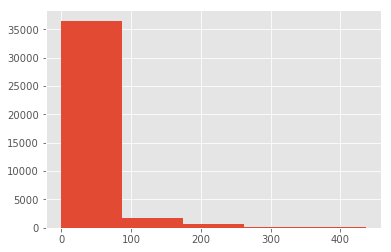

In [87]:
from matplotlib import pyplot as plt
plt.style.use("ggplot")
%matplotlib inline

plt.hist(issues_comments['exact_date_diff'], bins=5, label='Date diff')
plt.show()

In [88]:
tmp=issues_comments.loc[issues_comments['exact_date_diff']<5]
tmp.shape[0]/issues_comments.shape[0]

0.5101274552374141

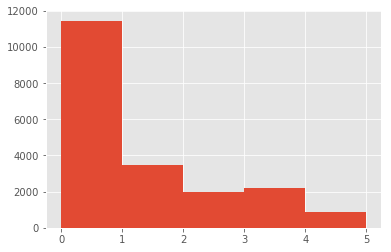

In [89]:
plt.hist(tmp['exact_date_diff'], bins=5, label='Date diff')
plt.show()

obviously, Group by date diff does not make any sense. Try group by action(open and close). It seems most of issues open and close at the same day.

In [90]:
import numpy as np
from nltk import corpus
from nltk import word_tokenize
from nltk.tokenize import RegexpTokenizer
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

def display_topics(model, feature_names):
    for i, topic in enumerate(model.components_):
        print("Topic %d:" % (i))
        print(" ".join([feature_names[i] for i in topic.argsort()[:-11 - 1:-1]]))
        
def lemmatize(text, stop=0):
    """
    Tokenization, and Stemming
    Input: text(string need to be cleaned), 
    Output: a tokenized, and stemmed list of words 
    """
    #Tokenization
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(text.lower())
    if stop==1:
        stopped = [word for word in tokens if word not in stopwords.words('english')]
    else:
        stopped=tokens
    #Stemming
    stemmer = PorterStemmer().stem
    return [stemmer(w.lower()) for w in stopped]

#vectorizition
tfidf_vectorizer=TfidfVectorizer(tokenizer=lemmatize,stop_words="english",smooth_idf=True, norm=None)
texts=issues_comments['comment'].tolist()
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 1 tgz yarnpkg registri 2 resolv babel 3 6 version
Topic 1:
08 active_pokemon_id search_worker_0 168 retri tabl pokestop column 23 warn 13
Topic 2:
19116 19147 breventserv 03 10 15 d com android tencent 13
Topic 3:
7 framework __getitem__ python ctype self cellar __init__ python2 2 usr
Topic 4:
s0 u c768 c512 scontext tcontext tclass avc object_r comm ino
Topic 5:
03 02 1052 13 47 14157 0 48 android 4187 com
Topic 6:
6208 breventserv 29 03 15 d 44 45 com android ele
Topic 7:
9172 9204 breventserv 03 15 10 47 com d v 48
Topic 8:
3d 0a 20 3b 3a 3anth 2f 20li 0aul 20background 20color
Topic 9:
04 breventserv 03 androidruntim d java 17 e 19 01 16787


In [18]:
query="SELECT * FROM issue_comment_events where comment like '%yarnpkg%' group by repo_id"
tmp = pd.read_sql(query, db)
tmp.shape

(6, 11)

In [46]:
query = "SELECT action, title,description FROM issues_events"
issue_comments_2 = pd.read_sql(query, db)
issue_comments_2=issue_comments.dropna(axis=0)
issue_comments_2['comment']=issue_comments_2['title']+issue_comments_2['description']
issue_comments_opened=issue_comments_2.loc[issue_comments_2['action'] == 'opened']['title'].tolist()
issue_comments_closed=issue_comments_2.loc[issue_comments_2['action'] == 'closed']['title'].tolist()

In [47]:
issue_comments_opened[:10]

['Regexp engines and regular expressions',
 'Usage: explain quickfix and location lists',
 'Usage: Introduction to VimL scripting',
 'Misc: History of Vim-like editors',
 'Usage: Good minimal vimrc',
 'Basics: Autocmds',
 'Usage: clipboard',
 'Intro: first steps',
 'Usage: bracketed paste',
 'Plugins: add demos that show off the workflow']

In [48]:
texts=issue_comments_opened
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 1 2 9 3 4 version 7 5 downgrad 6
Topic 1:
t doesn don isn updat won input load aren instal zappa
Topic 2:
error build messag pars javascript compil object modul thi load undefin
Topic 3:
add support option link type suggest new enhanc custom command abil
Topic 4:
file mix js css path compil download sass version directori onli
Topic 5:
use valid instead thi data chang input api node s select
Topic 6:
notif app io android receiv background crash push foreground icon fcm
Topic 7:
request featur scan type chang locat pokemon multipl pull issu option
Topic 8:
work doe map exampl valid properli doesnt doesn locat mix onli
Topic 9:
run npm fail instal dev build issu pipenv product window hot


It shows version downgrad is one of the top reason for issue opened action

In [49]:
texts=issue_comments_closed
tfidf=tfidf_vectorizer.fit_transform(texts)
tfidf_feature_names = tfidf_vectorizer.get_feature_names()
#Non-negative Matrix Factorization
nmf = NMF(n_components=10, random_state=1, alpha=.1, l1_ratio=.5, init='nndsvd').fit(tfidf)
display_topics(nmf, tfidf_feature_names)

Topic 0:
0 2 9 3 4 downgrad 11 updat 10 8 version
Topic 1:
t doesn don isn updat won aren display correctli chang input
Topic 2:
error build javascript pars messag thi compil modul server code map
Topic 3:
request featur scan chang pokemon multipl locat option type icon issu
Topic 4:
file mix js css path compil sass download version onli laravel
Topic 5:
use valid thi instead chang node data select input s make
Topic 6:
run app npm notif instal fail android dev io build crash
Topic 7:
add support option type new enhanc link abil s suggest custom
Topic 8:
1 2 7 5 6 3 x browser 3d android otp
Topic 9:
work doe map locat properli valid doesnt exampl doesn link stop


It shows update to the new version from downgrad

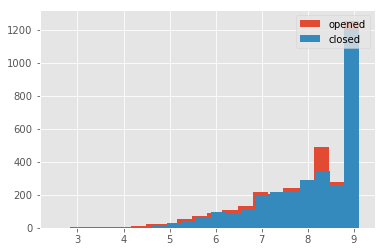

In [59]:
def text_dictionary(texts):
    textd={}
    for text in texts:
        #t=corpus.reuters.raw(text)
        s =set(lemmatize(text))
        try:
            toks=toks|s
        except NameError:
            toks=s
        for tok in s:
            try:
                textd[tok].append(text)
            except KeyError:
                    textd[tok]=[text]
    tok_list=list(toks)
    return [textd,tok_list]

def idf_smooth(texts):
    textd=text_dictionary(texts)[0]
    numd={key:len(set(val)) for key,val in textd.items()}
    logN=np.log(len(issue_comments['title']))
    return {key:logN-np.log(1+val) for key,val in numd.items() if val>1}

idf_smooth_opened=idf_smooth(issue_comments_opened)
idf_smooth_closed=idf_smooth(issue_comments_closed)

plt.hist(list(idf_smooth_opened.values()), bins=20, label='opened')
plt.hist(list(idf_smooth_closed.values()), bins=20,label='closed')
plt.legend(loc='upper right')
plt.show()

From above plot, we can know that the opened titles are typically cover the same content as colsed title.

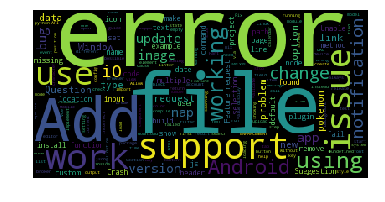

In [63]:
from wordcloud import WordCloud
wordcloud = WordCloud().generate(" ".join(issue_comments_opened))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

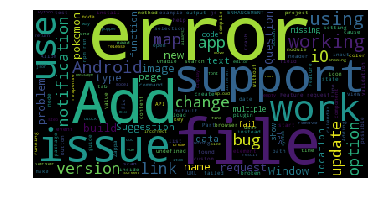

In [64]:
wordcloud = WordCloud().generate(" ".join(issue_comments_closed))
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

Word clouds also show the contents similarity between opened and colsed title